## Look at 201702 Bathymetry from Mesh Mask and create a TS file ##

In [3]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np 
import cmocean.cm as cm

from salishsea_tools import (
    bathy_tools,
    nc_tools,
    viz_tools,
)

%matplotlib inline

In [2]:
mesh = nc.Dataset('../../../../NEMO-forcing/grid/mesh_mask201702.nc')
mbathy = mesh.variables['mbathy'][0,:,:] 
#used to calculate number of vertical ocean grid cells at each (i,j) (1=land point)
gdepw = mesh.variables['gdepw_0'][0,:,:,:]
surface_tmask = mesh.variables['tmask'][0,0,:,:]
surface_tmask = np.abs(surface_tmask-1)
tmask = mesh.variables['tmask'][0,:,:,:]
tmask = np.abs(tmask-1)
lats = mesh.variables['nav_lat'][:]
lons = mesh.variables['nav_lon'][:]
mesh.close()

In [4]:
NEMO_bathy = np.zeros(mbathy.shape)
for i in range(NEMO_bathy.shape[1]):
    for j in range(NEMO_bathy.shape[0]):
        level = mbathy[j,i]
        NEMO_bathy[j,i] = gdepw[level,j,i]
NEMO_bathy = np.ma.masked_array(NEMO_bathy, mask = surface_tmask)

(47, 51.1)

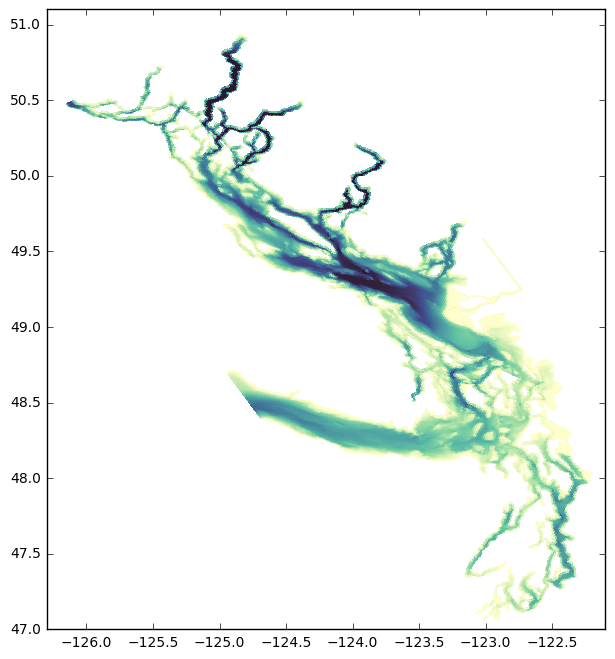

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
viz_tools.set_aspect(ax, coords='map')
plt.pcolormesh(lons, lats, NEMO_bathy, cmap=cm.deep)
ax.set_xlim((-126.3, -122.1))
ax.set_ylim((47, 51.1))

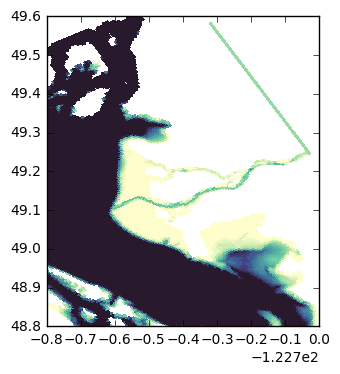

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(4,4))
viz_tools.set_aspect(ax, coords='map')
plt.pcolormesh(lons, lats, NEMO_bathy, cmap=cm.deep, vmax=35)
ax.set_xlim((-123.5, -122.7))
ax.set_ylim((48.8, 49.6));

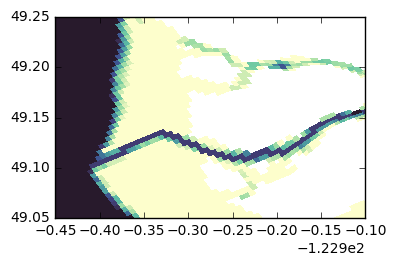

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(4,4))
viz_tools.set_aspect(ax, coords='map')
plt.pcolormesh(lons, lats, NEMO_bathy, cmap=cm.deep, vmax=15)
ax.set_xlim((-123.35, -123))
ax.set_ylim((49.05, 49.25));

In [9]:
oldmesh = nc.Dataset('../../../../NEMO-forcing/grid/mesh_mask_downbyone2.nc')
oldmbathy =oldmesh.variables['mbathy'][0,:,:] 
#used to calculate number of vertical ocean grid cells at each (i,j) (1=land point)
oldgdepw = oldmesh.variables['gdepw_0'][0,:,:,:]
oldsurface_tmask = oldmesh.variables['tmask'][0,0,:,:]
oldsurface_tmask = np.abs(oldsurface_tmask-1)
oldtmask = oldmesh.variables['tmask'][0,:,:,:]
oldtmask = np.abs(oldtmask-1)
oldmesh.close()

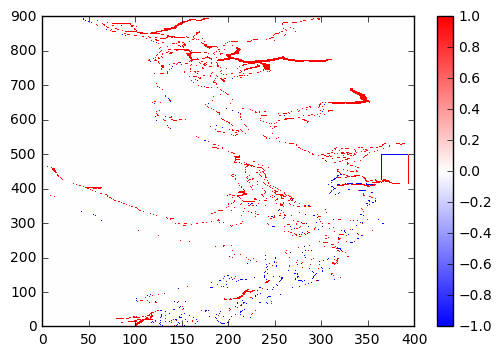

In [10]:
plt.pcolormesh(oldtmask[0]-tmask[0], cmap='bwr', vmax=1, vmin=-1)
plt.colorbar()

kmax = 0
fig, ax = plt.subplots(1, 1, figsize=(3,5))
for k in range(tmask.shape[0]):
    for i in range(tmask.shape[1]):
        for j in range(tmask.shape[2]):
            if tmask[k,i,j] < oldtmask[k,i,j]:
                if k == 0:
                    plt.plot(j, i, 'bo')
                else:
                    plt.plot(j, i, 'r+')
                    if k > kmax:
                        kmax = k
imin = 360; imax = 500; jmin = 290; jmax = 370
plt.xlim((jmin, jmax))
plt.ylim((imin, imax))
print (kmax)

In [11]:
kmax = 38

In [14]:
#dataphys = nc.Dataset('/results/SalishSea/nowcast-green/11sep16/SalishSea_00482400_restart.nc')
#databio = nc.Dataset('/results/SalishSea/nowcast-green/11sep16/SalishSea_00482400_restart_trc.nc')
dataphys = nc.Dataset('/ocean/sallen/allen/research/MEOPAR/myResults/SalishSea_00482400_restart.nc')
databio = nc.Dataset('/ocean/sallen/allen/research/MEOPAR/myResults/SalishSea_00482400_restart_trc_newNames.nc')

In [15]:
physical = ['tn', 'sn']
biological = ['TRNDON', 'TRNMICZ','TRNMYRI','TRNNH4','TRNNO3','TRNTRA',
              'TRNPHY','TRNDIAT','TRNPON','TRNSi','TRNbSi']
varas = {}
for vb in physical:
    temporary = dataphys.variables[vb][0, :]
    varas[vb] = np.ma.masked_array(temporary, mask = oldtmask)
for vb in biological:
    temporary = databio.variables[vb][0, :]
    varas[vb] = np.ma.masked_array(temporary, mask = oldtmask)
dataphys.close()
databio.close()
varall = physical + biological

In [16]:
def find_mean(varas, varall, i, j, k, dd):
    for vb in varall:
        lowi = max(0, i-dd)
        lowj = max(0, j-dd)
        varas[vb][k, i, j] = np.ma.mean(varas[vb][k, lowi:i+dd+1, lowj:j+dd+1])
    return varas

In [17]:
ksusan = kmax
print (ksusan, kmax)
dd = 1
bad = 1; badijk = [0, 0, 0]
while bad > 0:
    print ('dd', dd)
    dd += 1
    good = 1
    while good > 0:
        good = 0; bad = 0; already = 0
        for k in range(ksusan+1):
            for i in range(1, 898):
                for j in range(1, 398):
                    if tmask[k,i,j] < oldtmask[k,i,j]:
                        if varas['sn'][k, i, j] > 0:
                            already = already + 1
                        else:
                            varas = find_mean(varas, varall, i, j, k, dd)
                            if varas['sn'][k, i, j] > 0:
                                good = good + 1
                            else:
                                bad = bad + 1
                                badijk = [i, j, k]
            if (good > 0):
                print (k, 'good', good, 'bad', bad, badijk)
    print ('dd', dd)
    print ('done', already)
    print ('bad', bad)



38 38
dd 1
0 good 7127 bad 1002 [890, 172, 0]
1 good 14254 bad 2004 [890, 172, 1]
2 good 21381 bad 3006 [890, 172, 2]
3 good 28508 bad 4008 [890, 172, 3]
4 good 35137 bad 4975 [890, 172, 4]
5 good 41545 bad 5888 [890, 172, 5]
6 good 47751 bad 6726 [890, 172, 6]
7 good 53967 bad 7518 [890, 172, 7]
8 good 59944 bad 8295 [890, 172, 8]
9 good 65494 bad 9383 [896, 175, 9]
10 good 70982 bad 10381 [896, 175, 10]
11 good 76361 bad 11342 [896, 175, 11]
12 good 81674 bad 12280 [896, 175, 12]
13 good 86915 bad 13160 [896, 175, 13]
14 good 92059 bad 14047 [896, 175, 14]
15 good 97057 bad 14978 [896, 175, 15]
16 good 101979 bad 15905 [896, 175, 16]
17 good 106757 bad 16859 [896, 175, 17]
18 good 111434 bad 17786 [896, 175, 18]
19 good 116007 bad 18711 [896, 175, 19]
20 good 120336 bad 19665 [896, 175, 20]
21 good 124441 bad 20584 [896, 175, 21]
22 good 128256 bad 21580 [896, 175, 22]
23 good 131829 bad 22511 [896, 174, 23]
24 good 135001 bad 23391 [896, 174, 24]
25 good 137719 bad 24255 [896, 174, 

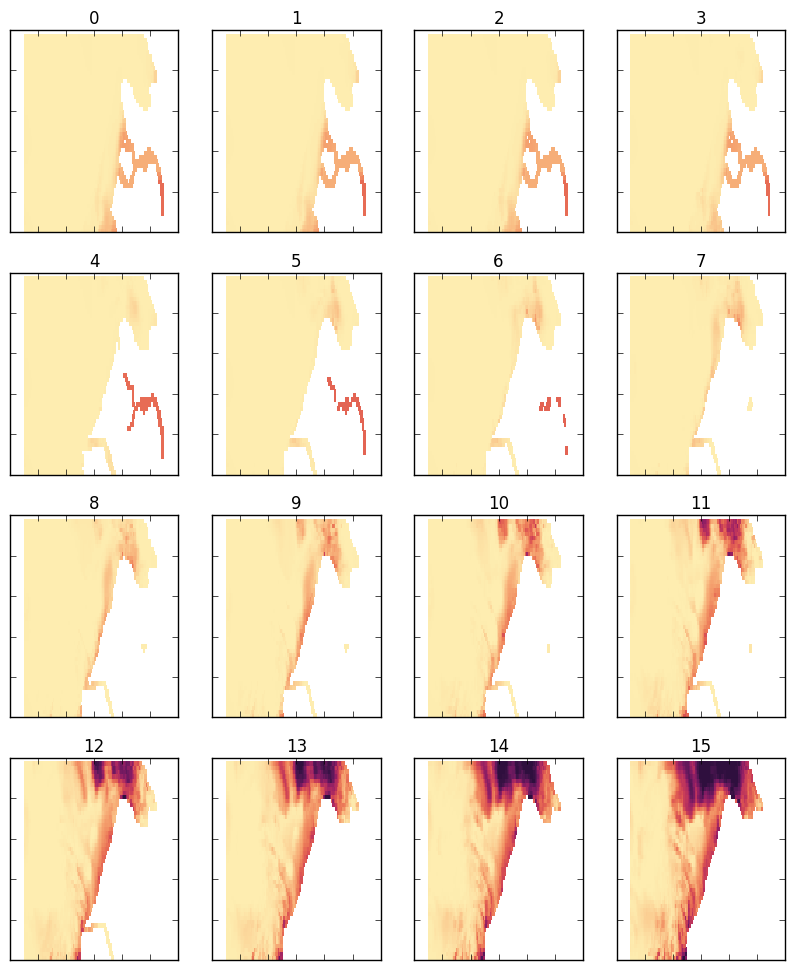

In [18]:
jmin=250; jmax=350; imin=420; imax=470;
fig, axs = plt.subplots(4, 4, figsize=(10,12))
for k, ax in enumerate([axs[0,0], axs[0, 1], axs[0, 2], axs[0, 3],
                         axs[1,0], axs[1, 1], axs[1, 2], axs[1,3],
                         axs[2,0], axs[2, 1], axs[2, 2], axs[2,3],
                         axs[3,0], axs[3, 1], axs[3, 2], axs[3,3]]):
    mesh = ax.pcolormesh(range(jmin, jmax), range(imin, imax), 
                         np.ma.masked_array(varas['TRNNO3'][k, imin:imax, jmin:jmax], tmask[k, imin:imax, jmin:jmax]),
                         cmap = cm.matter, vmax=16)
    ax.tick_params(axis='x', which='both', labelbottom='off')
    ax.tick_params(axis='y', which='both', labelleft='off')
    ax.set_title(k)

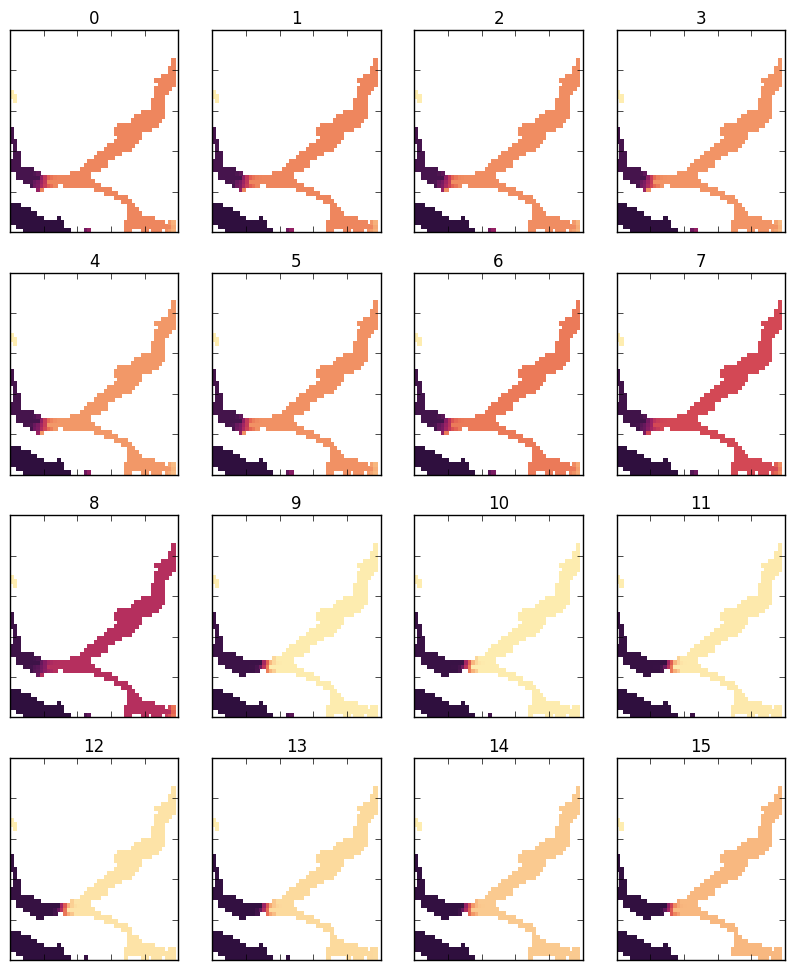

In [19]:
imin = 840; imax = 890; jmin=100; jmax=150
fig, axs = plt.subplots(4, 4, figsize=(10,12))
for k, ax in enumerate([axs[0,0], axs[0, 1], axs[0, 2], axs[0, 3],
                         axs[1,0], axs[1, 1], axs[1, 2], axs[1,3],
                         axs[2,0], axs[2, 1], axs[2, 2], axs[2,3],
                         axs[3,0], axs[3, 1], axs[3, 2], axs[3,3]]):
    mesh = ax.pcolormesh(range(jmin, jmax), range(imin, imax), 
                         np.ma.masked_array(varas['TRNNO3'][k, imin:imax, jmin:jmax], tmask[k, imin:imax, jmin:jmax]),
                         cmap = cm.matter, vmax=16)
    ax.tick_params(axis='x', which='both', labelbottom='off')
    ax.tick_params(axis='y', which='both', labelleft='off')
    ax.set_title(k)

In [25]:
# build nc file
new_initialfile = nc.Dataset('Bathy201702_initial.nc', 'w')
nc_tools.init_dataset_attrs(
    new_initialfile, 
    title='All tracers for Bathy 201702 from nowcast-green 11Sep2016', 
    notebook_name='analysis-susan/notebooks/TracersForBathymetry201702', 
    nc_filepath='NEMO-forcing/initial_strat/Bathy201702_initial.nc',
    comment='All Tracers, physical and biological')
new_initialfile.setncattr('references', 'NEMO-forcing/initial_strat/Bathy201702_initial.nc')
new_initialfile.createDimension('y', 898)
new_initialfile.createDimension('x', 398)
new_initialfile.createDimension('deptht', 40)
new_initialfile.createDimension('time_counter', None)

file format: NETCDF4
Conventions: CF-1.6
title: All tracers for Bathy 201702 from nowcast-green 11Sep2016
institution: Dept of Earth, Ocean & Atmospheric Sciences, University of British Columbia
source: https://bitbucket.org/salishsea/analysis-susan/src/tip/notebooks/bathymetry/analysis-susan/notebooks/TracersForBathymetry201702.ipynb
references: REQUIRED
history: [2017-04-15 10:03:36] Created netCDF4 zlib=True dataset.
comment: All Tracers, physical and biological


<class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time_counter', size = 0

In [26]:
thevara = {}
for vb in varall:
    thevara[vb] = new_initialfile.createVariable(
        vb, 'float32', ('time_counter', 'deptht', 'y', 'x'), zlib=True,
        least_significant_digit=1e-5, fill_value=0)
    thevara[vb][0] = varas[vb]
    print (np.max(thevara[vb]))
new_initialfile

21.9375
34.0
18.125
2.5625
2.625
7.375
48.6875
4067.31
2.625
11.8125
1.6875
112.5
9.1875


<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Conventions: CF-1.6
    title: All tracers for Bathy 201702 from nowcast-green 11Sep2016
    institution: Dept of Earth, Ocean & Atmospheric Sciences, University of British Columbia
    source: https://bitbucket.org/salishsea/analysis-susan/src/tip/notebooks/bathymetry/analysis-susan/notebooks/TracersForBathymetry201702.ipynb
    references: NEMO-forcing/initial_strat/Bathy201702_initial.nc
    history: [2017-04-15 10:03:36] Created netCDF4 zlib=True dataset.
    comment: All Tracers, physical and biological
    dimensions(sizes): y(898), x(398), deptht(40), time_counter(1)
    variables(dimensions): float32 tn(time_counter,deptht,y,x), float32 sn(time_counter,deptht,y,x), float32 TRNDON(time_counter,deptht,y,x), float32 TRNMICZ(time_counter,deptht,y,x), float32 TRNMYRI(time_counter,deptht,y,x), float32 TRNNH4(time_counter,deptht,y,x), float32 TRNNO3(time_counter,deptht,y,x), float32 TRNTRA(time_c

In [27]:
new_initialfile.close()

(1, 40, 898, 398)


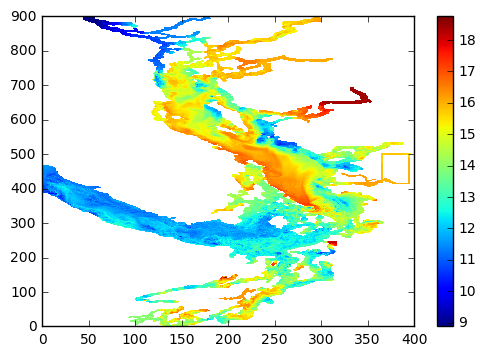

In [28]:
testfile = nc.Dataset('Bathy201702_initial.nc', 'r')
PHY = testfile.variables['tn']
print (PHY[:].shape)
plt.pcolormesh(PHY[0,5])
plt.colorbar()
testfile.close()

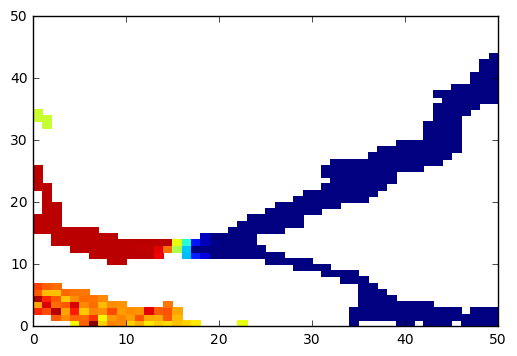

In [29]:
imin = 840; imax = 890; jmin=100; jmax=150
plt.pcolormesh(varas['sn'][10, imin:imax, jmin:jmax])

In [ ]:
plt.pcolormesh(tmask[0, imin:imax, jmin:jmax])

In [ ]:
plt.pcolormesh(oldtmask[0, imin:imax, jmin:jmax])